# Run QSVR experiments with multiple splits

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from random import randint, random
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import neal #import to use simulated annealing sampler
from dwave.system import LazyFixedEmbeddingComposite, DWaveSampler #import to select specific sampler
from scipy.stats import loguniform

In [4]:
search_svr_hps = False
experiment_name = ''
save = False
#date = datetime.datetime.now().strftime("_%Y_%m_%d-%I:%M:%S.%f_%p")
#experiment_name = experiment_name + date

### Run experiments with fixed epsilon, C and gamma

In [5]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
if search_svr_hps: #ONLY RUNS FOR FIXED SVR PARAMS: epsilon, C and gamma
	nb_utils.exit_cell('Exiting cell as search_svr_hps is set to True')

# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

rs = randint(0, 2**30)
num_runs = 0
r2 = np.zeros((num_runs, 7))
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rs+i)
	X_train = X_train[:79,:]
	y_train = y_train[:79]
	
	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	#set sampler
	#sampler = LazyFixedEmbeddingComposite(DWaveSampler(region='na-west-1', solver='Advantage_system6.1'))
	sampler = neal.SimulatedAnnealingSampler()
	qsvr_model.fit(X_train, y_train,
			K = 3, B = 0.5,
			epsilon = 0.02, k0 = 0.005,
			xi=0.01, n_samples = 20,
			#num_reads = 5000,
			num_reads=1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=40,
			gamma=0.1, C=67.61,
			use_custom_chainstrength=True,
			chain_mult=10,
			#anneal_time=40,
			sampler=sampler)
	
	if save: nb_utils.save_qsvr(qsvr_model, 'qsvr_attrs_'+experiment_name+'_rs'+str(rs)+'_i'+str(i)) # save QSVR for further predictions
	
	# evaluate QSVR
	y_pred = qsvr_model.predict(X_test)
	for j in range(7):
		r2[i,j] = r2_score(y_pred[j],y_test)
	print(f'Finished run {i} with r2 = {r2[i,:]} with mean = {r2[i,:].mean()}')

results = {
	'scores norm' : r2[:,0],
	'scores softmax' : r2[:,1],
	'scores lc norm' : r2[:,2],
	'scores lc softmax' : r2[:,3],
	'best set of alphas' : r2[:,4],
	'simple mean' : r2[:,5],
	'min energy' : r2[:,6]
}

if save: dump(results, 'results_'+experiment_name+'_rs'+str(rs)+'.joblib')

for k in results.keys():
	print(f'{k}: {results[k]}')

best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
no field of name chain_break_fraction
->trying with: result = rfn.merge_arrays((unique_samples, unique_records["energy"], unique_counts))
Finished run 0 with r2 = [0.93803704 0.93794904 0.93803676 0.93934146 0.93786938 0.93792147
 0.92969095] with mean = 0.9369780146628436
best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
no field of name chain_break_fraction
->trying with: result = rfn.merge_arrays((unique_samples, unique_records["energy"], unique_counts))
Finished run 1 with r2 = [0.71710789 0.76118557 0.71705811 0.74572716 0.770359   0.71157219
 0.75580076] with mean = 0.7398300953434417
best v

### Run experiments searching for epsilon, C and gamma

In [59]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
if not search_svr_hps: #ONLY RUNS if user wants to search for: epsilon, C and gamma
	nb_utils.exit_cell('Exiting cell as search_svr_hps is set to False')
	
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

rs = randint(0, 2**30)
num_runs = 0
r2 = np.zeros((num_runs, 7))
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=rs+i)

	# Optimiza SVR hps using classical SVR
	best, C_best, epsilon_best, gamma_best = -100, None, None, None
	for j in range(5000):
		#C = loguniform.rvs(1e0,1e3)
		C = loguniform.rvs(5.0,1e3) # after experiment this range seems probably better for qsvr 
		#gamma = loguniform.rvs(1e-5,10)
		gamma = loguniform.rvs(0.01,10) # after experiment this range seems probably better for qsvr 
		#epsilon = loguniform.rvs(1e-3,1e0)
		epsilon = loguniform.rvs(1e-3,0.4) # after experiment this range seems probably better for qsvr 
		model = SVR(C=C,epsilon=epsilon,gamma=gamma)
		cvs, __ = nb_utils.small_train_r2_cv(model, X=X_train, y=y_train, train_size= 20, reps=5, test_size=0.74,rs=rs+j)
		cvs = cvs.mean()
		if best < cvs:
			best = cvs
		C_best, epsilon_best, gamma_best = C, epsilon, gamma
	
	B = 0.5
	K = 3
	k0 = 0.005
	exponents_array = np.array(list(range(K)))
	exponents_array = exponents_array-k0
	C_min = sum(np.power(B, exponents_array))
	
	if (C_best < C_min): 
		C_best = C_min
			
	print(pd.DataFrame({'CV mean R^2': best, 'C': C_best, 'epsilon': epsilon_best, 'gamma': gamma_best}, index=['Best hyperparameters']))

	X_train, _, y_train, _ = train_test_split(X, y, train_size=20, random_state=rs+i)

	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	#set sampler
	sampler = LazyFixedEmbeddingComposite(DWaveSampler(region='na-west-1', solver='Advantage_system6.1'))
	qsvr_model.fit(X_train, y_train,
			K = K, B = B,
			epsilon = epsilon_best, k0 = k0,
			xi=0.01, n_samples = 20, num_reads = 1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=0,
			gamma=gamma_best, C=C_best,
			use_custom_chainstrength=True,
			chain_mult=8,
			sampler=sampler)
	
	if save: nb_utils.save_qsvr(qsvr_model, 'qsvr_attrs_'+experiment_name+'_rs'+str(rs)+'_i'+str(i)) # save QSVR for further predictions
	# evaluate QSVR
	y_pred = qsvr_model.predict(X_test)
	for j in range(7):
		r2[i,j] = r2_score(y_pred[j],y_test)
	print(f'Finished run {i} with r2 = {r2[i,:]}')
results = {
	'scores norm' : r2[:,0],
	'scores softmax' : r2[:,1],
	'scores lc norm' : r2[:,2],
	'scores lc softmax' : r2[:,3],
	'best set of alphas' : r2[:,4],
	'simple mean' : r2[:,5]
}

if save: dump(results, 'results_'+experiment_name+'_rs'+str(rs)+'.joblib')

for k in results.keys():
	print(f'{k}: {results[k]}')

2022-08-23 15:11:02,505 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 15:11:02,553 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 15:11:02,555 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 15:11:02,556 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2          C   epsilon     gamma
Best hyperparameters      0.94124  11.895856  0.069008  0.130175


2022-08-23 15:11:04,149 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 15:11:04,207 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 15:11:04,208 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.06666667 0.05       0.15       0.13333333 0.10833333 0.075
 0.10833333 0.05833333 0.1        0.1        0.09166667 0.125
 0.06666667 0.1        0.06666667 0.08333333 0.08333333 0.05833333
 0.09166667 0.08333333 0.13333333 0.10833333 0.05833333 0.1
 0.05833333 0.1        0.075      0.10833333 0.11666667 0.06666667
 0.10833333 0.05       0.1        0.08333333 0.11666667 0.1
 0.09166667 0.05       0.06666667 0.125      0.15       0.11666667
 0.09166667 0.1        0.09166667 0.075      0.09166667 0.06666667
 0.06666667 0.14166667 0.04166667 0.175      0.03333333 0.05833333
 0.025      0.16666667 0.09166667 0.10833333 0.09166667 0.15833333
 0.05       0.10833333 0.125      0.06666667 0.15       0.05
 0.06666667 0.04166667 0.05       0.10833333 0.10833333 0.11666667
 0.06666667 0.04166667 0.09166667 0.09166667 0.06666667 0.

2022-08-23 15:16:05,297 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 15:16:05,342 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 15:16:05,344 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 15:16:05,345 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2         C   epsilon     gamma
Best hyperparameters     0.947135  8.557137  0.001088  0.002132


2022-08-23 15:16:06,854 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 15:16:06,908 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 15:16:06,909 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.025      0.05       0.05       0.025      0.04166667 0.05
 0.03333333 0.05       0.025      0.05833333 0.05833333 0.025
 0.03333333 0.05       0.         0.         0.05       0.04166667
 0.05833333 0.025      0.03333333 0.01666667 0.04166667 0.01666667
 0.01666667 0.05833333 0.025      0.03333333 0.05833333 0.025
 0.01666667 0.05833333 0.05833333 0.03333333 0.05833333 0.05833333
 0.05833333 0.01666667 0.04166667 0.03333333 0.05833333 0.075
 0.04166667 0.05       0.04166667 0.01666667 0.04166667 0.05833333
 0.04166667 0.05833333 0.05       0.04166667 0.06666667 0.05833333
 0.05833333 0.025      0.025      0.03333333 0.025      0.04166667
 0.025      0.05833333 0.025      0.025      0.01666667 0.03333333
 0.04166667 0.04166667 0.05833333 0.04166667 0.025      0.01666667
 0.03333333 0.03333333 0.01666667 0.075      0.05

2022-08-23 15:24:19,578 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 15:24:19,636 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 15:24:19,637 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 15:24:19,639 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2          C   epsilon     gamma
Best hyperparameters     0.957112  12.722763  0.001465  0.003099


2022-08-23 15:24:21,153 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 15:24:21,206 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 15:24:21,207 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.03333333 0.05833333 0.03333333 0.03333333 0.06666667 0.025
 0.05833333 0.04166667 0.03333333 0.00833333 0.025      0.025
 0.03333333 0.025      0.04166667 0.05833333 0.025      0.025
 0.05833333 0.075      0.01666667 0.06666667 0.00833333 0.025
 0.05       0.01666667 0.075      0.03333333 0.05       0.04166667
 0.05       0.025      0.04166667 0.05       0.025      0.06666667
 0.03333333 0.01666667 0.05       0.03333333 0.08333333 0.04166667
 0.05833333 0.01666667 0.01666667 0.         0.025      0.00833333
 0.075      0.05833333 0.05833333 0.04166667 0.03333333 0.05
 0.05       0.04166667 0.025      0.05       0.04166667 0.00833333
 0.04166667 0.03333333 0.06666667 0.04166667 0.03333333 0.01666667
 0.03333333 0.05       0.05       0.025      0.05833333 0.03333333
 0.025      0.03333333 0.08333333 0.04166667 0.0666666

2022-08-23 15:29:18,659 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 15:29:18,718 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 15:29:18,720 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 15:29:18,721 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2         C  epsilon     gamma
Best hyperparameters     0.918055  2.424822  0.53752  0.004837


2022-08-23 15:29:23,103 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 15:29:23,159 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 15:29:23,161 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.05       0.025      0.01666667 0.04166667 0.05833333 0.04166667
 0.05       0.05       0.08333333 0.00833333 0.025      0.06666667
 0.01666667 0.05833333 0.04166667 0.025      0.06666667 0.06666667
 0.025      0.025      0.03333333 0.         0.04166667 0.03333333
 0.04166667 0.03333333 0.05       0.04166667 0.08333333 0.03333333
 0.06666667 0.05833333 0.06666667 0.04166667 0.04166667 0.05833333
 0.03333333 0.05833333 0.01666667 0.05       0.025      0.03333333
 0.03333333 0.05       0.04166667 0.01666667 0.05833333 0.04166667
 0.04166667 0.00833333 0.05       0.         0.05       0.03333333
 0.06666667 0.075      0.04166667 0.06666667 0.05       0.05833333
 0.025      0.05       0.025      0.00833333 0.04166667 0.04166667
 0.03333333 0.05833333 0.025      0.075      0.05833333 0.05833333
 0.04166667 0.04166667 0.066

2022-08-23 15:34:49,018 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 15:34:49,101 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 15:34:49,103 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 15:34:49,104 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2         C   epsilon     gamma
Best hyperparameters     0.885895  1.756076  0.071788  0.000033


2022-08-23 15:34:50,623 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 15:34:50,681 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 15:34:50,684 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.05       0.01666667 0.03333333 0.03333333 0.06666667 0.04166667
 0.03333333 0.05833333 0.05833333 0.04166667 0.03333333 0.
 0.01666667 0.075      0.05       0.05       0.01666667 0.05833333
 0.04166667 0.05       0.025      0.05       0.00833333 0.025
 0.05       0.01666667 0.01666667 0.05       0.025      0.075
 0.05833333 0.05       0.03333333 0.025      0.03333333 0.04166667
 0.03333333 0.025      0.05       0.05       0.06666667 0.00833333
 0.00833333 0.04166667 0.04166667 0.05       0.04166667 0.05833333
 0.03333333 0.         0.025      0.025      0.025      0.03333333
 0.03333333 0.03333333 0.04166667 0.04166667 0.03333333 0.05833333
 0.05833333 0.05       0.05833333 0.00833333 0.01666667 0.04166667
 0.01666667 0.04166667 0.05       0.025      0.04166667 0.025
 0.025      0.05       0.05833333 0.01666667 0.05  

2022-08-23 15:43:52,322 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 15:43:52,410 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 15:43:52,412 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 15:43:52,414 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2         C   epsilon     gamma
Best hyperparameters     0.921078  4.732459  0.532605  0.122248


2022-08-23 15:43:53,965 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 15:43:54,034 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 15:43:54,037 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.05       0.04166667 0.03333333 0.01666667 0.025      0.04166667
 0.01666667 0.03333333 0.01666667 0.025      0.05833333 0.05
 0.01666667 0.03333333 0.01666667 0.03333333 0.025      0.01666667
 0.03333333 0.025      0.04166667 0.075      0.00833333 0.05
 0.05       0.03333333 0.03333333 0.04166667 0.05       0.04166667
 0.01666667 0.         0.01666667 0.03333333 0.025      0.03333333
 0.01666667 0.03333333 0.05833333 0.03333333 0.03333333 0.00833333
 0.01666667 0.01666667 0.01666667 0.00833333 0.01666667 0.04166667
 0.         0.06666667 0.03333333 0.01666667 0.025      0.03333333
 0.025      0.025      0.01666667 0.03333333 0.05       0.05
 0.025      0.00833333 0.025      0.01666667 0.03333333 0.03333333
 0.03333333 0.025      0.01666667 0.01666667 0.04166667 0.01666667
 0.00833333 0.025      0.025      0.03333333 0

2022-08-23 15:55:58,007 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 15:55:58,063 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 15:55:58,065 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 15:55:58,066 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2           C   epsilon     gamma
Best hyperparameters     0.889231  152.124312  0.042031  3.830185


2022-08-23 15:55:59,590 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 15:55:59,648 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 15:55:59,649 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.10833333 0.075      0.05       0.10833333 0.025      0.06666667
 0.1        0.09166667 0.09166667 0.1        0.08333333 0.08333333
 0.075      0.125      0.04166667 0.09166667 0.075      0.13333333
 0.13333333 0.03333333 0.06666667 0.1        0.08333333 0.1
 0.11666667 0.06666667 0.1        0.09166667 0.11666667 0.06666667
 0.16666667 0.06666667 0.1        0.10833333 0.09166667 0.075
 0.06666667 0.10833333 0.075      0.04166667 0.09166667 0.08333333
 0.075      0.08333333 0.08333333 0.10833333 0.09166667 0.09166667
 0.075      0.075      0.03333333 0.11666667 0.08333333 0.1
 0.1        0.075      0.09166667 0.06666667 0.06666667 0.06666667
 0.075      0.06666667 0.08333333 0.06666667 0.1        0.05833333
 0.1        0.075      0.08333333 0.125      0.10833333 0.04166667
 0.1        0.05833333 0.1        0.14166667 0.

2022-08-23 16:01:46,647 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 16:01:46,715 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 16:01:46,717 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 16:01:46,718 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2          C   epsilon     gamma
Best hyperparameters     0.895467  14.425625  0.004402  0.022942


2022-08-23 16:01:48,275 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 16:01:48,331 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 16:01:48,332 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.03333333 0.025      0.         0.05       0.04166667 0.04166667
 0.025      0.08333333 0.025      0.01666667 0.01666667 0.04166667
 0.01666667 0.00833333 0.04166667 0.00833333 0.01666667 0.00833333
 0.05       0.025      0.05       0.01666667 0.025      0.025
 0.025      0.01666667 0.03333333 0.01666667 0.01666667 0.05
 0.025      0.03333333 0.05       0.01666667 0.04166667 0.00833333
 0.025      0.025      0.05833333 0.03333333 0.03333333 0.00833333
 0.03333333 0.025      0.025      0.025      0.01666667 0.03333333
 0.00833333 0.05       0.01666667 0.05       0.01666667 0.03333333
 0.05       0.025      0.04166667 0.025      0.03333333 0.05833333
 0.06666667 0.04166667 0.01666667 0.03333333 0.025      0.05833333
 0.00833333 0.05833333 0.01666667 0.025      0.025      0.05
 0.01666667 0.03333333 0.01666667 0.05       

2022-08-23 16:06:43,283 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 16:06:43,424 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 16:06:43,426 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 16:06:43,427 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2           C   epsilon     gamma
Best hyperparameters     0.947787  275.514086  0.048069  3.006663


2022-08-23 16:06:44,958 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 16:06:45,016 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 16:06:45,017 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.05       0.03333333 0.03333333 0.03333333 0.075      0.04166667
 0.025      0.075      0.03333333 0.075      0.025      0.04166667
 0.06666667 0.00833333 0.04166667 0.05       0.025      0.05
 0.03333333 0.05       0.01666667 0.04166667 0.025      0.05833333
 0.075      0.11666667 0.00833333 0.04166667 0.05       0.05
 0.06666667 0.05833333 0.025      0.04166667 0.05833333 0.03333333
 0.05833333 0.03333333 0.03333333 0.03333333 0.03333333 0.00833333
 0.05       0.025      0.06666667 0.05       0.05833333 0.075
 0.01666667 0.025      0.01666667 0.05       0.05       0.01666667
 0.03333333 0.05       0.04166667 0.04166667 0.08333333 0.05
 0.03333333 0.025      0.03333333 0.06666667 0.04166667 0.05
 0.06666667 0.025      0.04166667 0.05833333 0.03333333 0.04166667
 0.03333333 0.05       0.01666667 0.08333333 0.06666667 0

2022-08-23 16:15:15,976 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 16:15:16,060 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 16:15:16,063 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 16:15:16,065 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


                      CV mean R^2         C   epsilon     gamma
Best hyperparameters      0.86975  5.902724  0.658671  0.284709


2022-08-23 16:15:17,627 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 16:15:17,696 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 16:15:17,700 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.04166667 0.04166667 0.04166667 0.04166667 0.025      0.01666667
 0.03333333 0.03333333 0.03333333 0.03333333 0.05833333 0.03333333
 0.03333333 0.05       0.05833333 0.04166667 0.025      0.05
 0.04166667 0.04166667 0.06666667 0.04166667 0.04166667 0.03333333
 0.00833333 0.03333333 0.04166667 0.06666667 0.03333333 0.05833333
 0.01666667 0.04166667 0.025      0.03333333 0.04166667 0.05
 0.05833333 0.03333333 0.04166667 0.03333333 0.00833333 0.03333333
 0.075      0.04166667 0.025      0.03333333 0.03333333 0.00833333
 0.01666667 0.03333333 0.05833333 0.025      0.01666667 0.075
 0.05       0.03333333 0.04166667 0.05       0.05833333 0.05
 0.05833333 0.03333333 0.03333333 0.04166667 0.04166667 0.05
 0.03333333 0.05833333 0.03333333 0.05833333 0.06666667 0.04166667
 0.06666667 0.04166667 0.03333333 0.05833333 0.01666667 0

### Analize experiment results

All r2 metrics:
mean = 0.9006900206768235 
max = 0.948731538209798 
min = 0.38306354174632673 
median = 0.90981298469417 
std = 0.045835082512278975


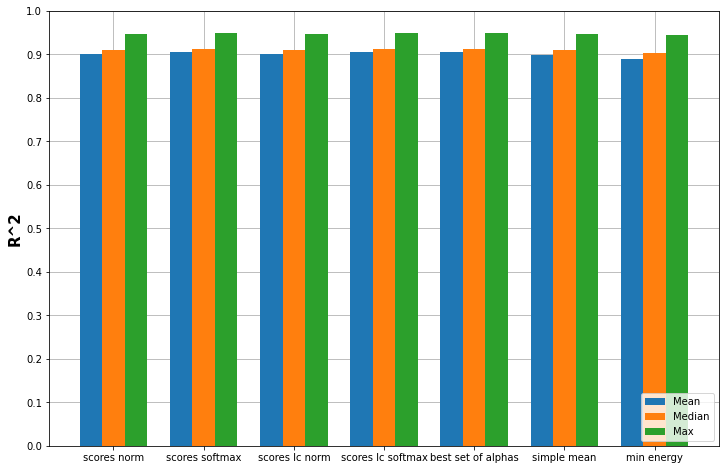

In [6]:
all_r2 = r2.flatten()
print(f'All r2 metrics:\nmean = {all_r2.mean()} \nmax = {all_r2.max()} \nmin = {all_r2.min()} \nmedian = {np.median(all_r2)} \nstd = {all_r2.std()}')


#results = load('results_B10_g01_k005_xi01_c67_rs'+str(rs)+'.joblib')
barWidth = 0.25

fig = plt.subplots(figsize =(12, 8))
plt.grid()
plt.gca().set_axisbelow(True)
 
# set height of bar
#MIN = [val.min() for val in results.values()]
MEAN = [val.mean() for val in results.values()]
MEDIAN = [np.median(val) for val in results.values()]
MAX = [val.max() for val in results.values()]
 
# Set position of bar on X axis
br1 = np.arange(len(results))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, MEAN, width = barWidth, label ='Mean')
plt.bar(br2, MEDIAN, width = barWidth, label ='Median')
plt.bar(br3, MAX, width = barWidth, label ='Max')

# Adding Xticks
plt.ylabel('R^2', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(results.keys()))], list(results.keys()))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(loc = 'lower right')
plt.show()

In [5]:
summary = pd.DataFrame(columns = ['method', 'min', 'max', 'mean', 'median', 'std'])
for k in results.keys():
    summary.loc[len(summary.index)] =[k,
        results[k].min(),
        results[k].max(),
        results[k].mean(),
        np.median(results[k]),
        results[k].std()]
summary

,method,min,max,mean,median,std
0,scores norm,0.642092,0.935184,0.851586,0.877667,0.080158
1,scores softmax,0.734915,0.923678,0.874933,0.887920,0.053824
2,scores lc norm,0.640867,0.935162,0.851302,0.877711,0.080599
3,scores lc softmax,0.753188,0.923866,0.876492,0.893137,0.046601
4,best set of alphas,0.719102,0.923678,0.867357,0.884141,0.058313
5,simple mean,0.545762,0.928396,0.802832,0.842232,0.124264
6,min energy,-2.531158,0.855326,0.091985,0.653538,1.133706


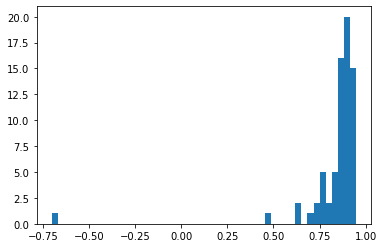

In [9]:
plt.hist(r2.flatten(),bins=50)
plt.show()

In [64]:
for k in results.keys():
	print(f'{k}: {results[k]}')

scores norm: [ 7.96514815e-01 -6.99377533e+01 -2.03972045e+01 -1.59740127e+03
 -1.71701318e+05 -2.25379145e+00  3.56998030e-01  7.06439333e-01
  5.46678456e-01 -6.90381005e+00]
scores softmax: [ 6.60420725e-01 -6.67173612e+01 -1.87468893e+01 -1.59697838e+03
 -1.68366427e+05 -2.11614967e+00  2.22093354e-01  8.07566721e-01
  2.61936041e-01 -6.88659383e+00]
scores lc norm: [ 7.96424121e-01 -6.99680497e+01 -2.04174619e+01 -1.60751256e+03
 -1.71852075e+05 -2.29805375e+00  3.69600697e-01  7.06087726e-01
  5.54232886e-01 -7.38530908e+00]
scores lc softmax: [ 7.80178918e-01 -7.02057920e+01 -2.05510370e+01 -1.67727309e+03
 -1.72639703e+05 -2.53715684e+00  4.79016912e-01  7.79070235e-01
  6.39290374e-01 -1.07558350e+01]
best set of alphas: [ 6.81683379e-01 -4.84178667e+01 -1.43570940e+01 -4.78004177e+02
 -1.56000064e+05 -8.48345412e-01  1.25670760e-01  8.07313334e-01
  2.94663702e-01 -8.77666616e-01]
simple mean: [ 7.96794728e-01 -7.07819464e+01 -2.09352189e+01 -1.69111269e+03
 -1.73380707e+05 -

### Generate a data frame with the SVR hps and the R^2 values

In [68]:
sufix = '_eric_params_chain_strength_hp_search_rs291682655_i' # write the date extension of the model you want to load
#ld_x_scaler = load("x_scaler_q"+sufix+".joblib") 
#ld_y_scaler = load("y_scaler_q"+sufix+".joblib")
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

info = pd.DataFrame(columns = ['epsilon', 'C', 'gamma', 'scores norm', 'scores softmax', 'scores lc norm', 'scores lc softmax', 'best set of alphas', 'simple mean', 'min energy', 'mean'])
rs = 291682655
for i in range(10):
    ld_qsvr_attrs = load("qsvr_attrs"+sufix+str(i)+".joblib")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=rs+i)

    epsilon = ld_qsvr_attrs["epsilon"]
    gamma = ld_qsvr_attrs["best_gamma"]
    C = ld_qsvr_attrs["best_C"]
    row = [epsilon, C, gamma]

    pred_model = QSVR.QSVR() 
    
    # set the QSVR attributes needed for predictions
    for attr in ld_qsvr_attrs.keys():
        setattr(pred_model, attr, ld_qsvr_attrs[attr])


    # use the QSVR to do a prediction
    # loaded scalers may be needed
    y_pred = pred_model.predict(X_test)

    # make use of the prediction
    r2s = []
    for i in range(y_pred.shape[0]):
        r2s.append(r2_score(y_pred[i],y_test))

    row.extend(r2s)
    row.append(np.array(r2s).mean())

    info.loc[len(info.index)] = row

info

,epsilon,C,gamma,scores norm,scores softmax,scores lc norm,scores lc softmax,best set of alphas,simple mean,min energy,mean
0,0.069008,11.895856,0.130175,0.796515,0.660421,0.796424,0.780179,0.681683,0.796795,0.235709,0.678247
1,0.001088,8.557137,0.002132,-69.937753,-66.717361,-69.968050,-70.205792,-48.417867,-70.781946,-71.730570,-66.822763
2,0.001465,12.722763,0.003099,-20.397204,-18.746889,-20.417462,-20.551037,-14.357094,-20.935219,-15.663748,-18.724093
3,0.537520,2.424822,0.004837,-1597.401271,-1596.978376,-1607.512563,-1677.273093,-478.004177,-1691.112689,-478.004177,-1303.755192
4,0.071788,1.756076,0.000033,-171701.318456,-168366.426574,-171852.074686,-172639.702825,-156000.064034,-173380.707293,-194377.590470,-172616.840620
5,0.532605,4.732459,0.122248,-2.253791,-2.116150,-2.298054,-2.537157,-0.848345,-2.615620,-0.848345,-1.931066
6,0.042031,152.124312,3.830185,0.356998,0.222093,0.369601,0.479017,0.125671,0.535466,0.121846,0.315813
7,0.004402,14.425625,0.022942,0.706439,0.807567,0.706088,0.779070,0.807313,0.660599,0.458125,0.703600
8,0.048069,275.514086,3.006663,0.546678,0.261936,0.554233,0.639290,0.294664,0.679916,0.294664,0.467340
9,0.658671,5.902724,0.284709,-6.903810,-6.886594,-7.385309,-10.755835,-0.877667,-11.711973,-6.655262,-7.310921


### Redo an experiment now using simulated annealing

In [69]:
sufix = '_eric_params_chain_strength_hp_search_rs291682655_i' # write the date extension of the model you want to load
#ld_x_scaler = load("x_scaler_q"+sufix+".joblib") 
#ld_y_scaler = load("y_scaler_q"+sufix+".joblib")
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

annealed_info = pd.DataFrame(columns = ['epsilon', 'C', 'gamma', 'scores norm', 'scores softmax', 'scores lc norm', 'scores lc softmax', 'best set of alphas', 'simple mean', 'min energy', 'mean'])
rs = 291682655
for i in range(10):
	ld_qsvr_attrs = load("qsvr_attrs"+sufix+str(i)+".joblib")
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=rs+i)
	X_train, _, y_train, _ = train_test_split(X, y, train_size=20, random_state=rs+i)

	epsilon = ld_qsvr_attrs["epsilon"]
	gamma = ld_qsvr_attrs["best_gamma"]
	C = ld_qsvr_attrs["best_C"]
	row = [epsilon, C, gamma]
	B = 0.5
	K = 3
	k0 = 0.005

	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	#set sampler
	sampler = neal.SimulatedAnnealingSampler()
	qsvr_model.fit(X_train, y_train,
			K = K, B = B,
			epsilon = epsilon, k0 = k0,
			xi=0.01, n_samples = 20, num_reads = 1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=0,
			gamma=gamma, C=C,
			use_custom_chainstrength=True,
			chain_mult=8,
			sampler=sampler)

	# use the QSVR to do a prediction
	# loaded scalers may be needed
	y_pred = pred_model.predict(X_test)

	# make use of the prediction
	r2s = []
	for i in range(y_pred.shape[0]):
		r2s.append(r2_score(y_pred[i],y_test))

	row.extend(r2s)
	row.append(np.array(r2s).mean())

	annealed_info.loc[len(annealed_info.index)] = row

annealed_info

Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
no field of name chain_break_fraction
->trying with: result = rfn.merge_arrays((unique_samples, unique_records["energy"], unique_counts))
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
no field of name chain_break_fraction
->trying with: result = rfn.merge_arrays((unique_samples, unique_records["energy"], unique_counts))
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
no field of name chain_break_fraction
->trying with: result = rfn.merge_arrays((unique_samples, unique_records["energy"], unique_counts))
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q

,epsilon,C,gamma,scores norm,scores softmax,scores lc norm,scores lc softmax,best set of alphas,simple mean,min energy,mean
0,0.069008,11.895856,0.130175,-6.720145,-6.698243,-7.162874,-10.267389,-0.968319,-11.141030,-5.723087,-6.954441
1,0.001088,8.557137,0.002132,-6.973621,-6.946910,-7.414123,-10.524024,-1.062460,-11.395931,-5.653368,-7.138634
2,0.001465,12.722763,0.003099,-7.256406,-7.239204,-7.769835,-11.347216,-0.901527,-12.362941,-6.180577,-7.579672
3,0.537520,2.424822,0.004837,-6.090509,-6.067126,-6.493835,-9.364508,-0.795315,-10.174353,-6.523963,-6.501373
4,0.071788,1.756076,0.000033,-6.532857,-6.506916,-6.960830,-10.001350,-0.872923,-10.857462,-6.549294,-6.897376
5,0.532605,4.732459,0.122248,-6.981381,-6.957746,-7.451174,-10.792587,-0.885965,-11.738723,-6.747461,-7.365005
6,0.042031,152.124312,3.830185,-6.405725,-6.379122,-6.821988,-9.806455,-0.825647,-10.645579,-6.419056,-6.757653
7,0.004402,14.425625,0.022942,-6.912265,-6.887125,-7.367833,-10.585006,-0.940105,-11.491345,-6.209398,-7.199011
8,0.048069,275.514086,3.006663,-6.567930,-6.555132,-7.032883,-10.240034,-0.900474,-11.151084,-5.876470,-6.903430
9,0.658671,5.902724,0.284709,-6.903810,-6.886594,-7.385309,-10.755835,-0.877667,-11.711973,-6.655262,-7.310921


In [6]:
r2[1,:]

array([ 0.64209213,  0.73491521,  0.64086728,  0.75318825,  0.71910172,
        0.5457623 , -2.53115753])